<a href="https://colab.research.google.com/github/wri/aqueduct_analyze_locations/blob/master/Y2019M09D12_RH_Generate_Random_Valid_Addresses_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate a .csv file with an arbitrary number of valid addresses.

In [1]:
!pip install geopy geopandas

In [2]:
!apt install python3-rtree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
import getpass
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import GoogleV3

In [4]:
initiate = True
if initiate:
  api_key = getpass.getpass("Google API key: ")
else:
  pass

Google API key: ··········


In [0]:
# We do not know how many locations are randomly sampled on land. 
# Appr. 1/3 of the world is land and we exclude antarctica. Therefor we multiply
# by 6 (safe side). 

desired_sample_size = 100
sample_size = 6*desired_sample_size

In [0]:
def scale_lat(rand):
  return rand*180-90

def scale_lon(rand):
  return rand*360-180


def get_random_dataframe(sample_size):
  lats = list(map(scale_lat,np.random.rand(sample_size)))
  lons = list(map(scale_lon,np.random.rand(sample_size)))
  df = pd.DataFrame(data={"lat":lats,"lon":lons})
  gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
  gdf.crs = {'init':'epsg:4326'}
  return df, gdf


geolocator = GoogleV3(api_key=api_key)
def reverse_geocode(row):
  location = geolocator.reverse([row.lat, row.lon],exactly_one=True)
  if location:
    address = location.address  #use most specific address, see https://developers.google.com/maps/documentation/geocoding/intro#reverse-example
  else:
    address = np.nan
  return address


def mask_ocean(gdf):
  world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
  )
  gdf_land = gpd.sjoin(gdf, world, how="inner", op='intersects')
  gdf_land = gdf_land.loc[gdf_land["continent"] != 'Antarctica']
  print(gdf_land.shape)
  return gdf_land

def export_address(gdf):
  gdf["id"] = gdf_land.index
  gdf["location_name"] = "test"
  
  df = gdf[["id","location_name","address"]]
  
  datetime_string = datetime.datetime.now().isoformat()
  filename = "export_address_{}_{}_V01.csv".format(desired_sample_size,datetime_string)
  df = df[0:desired_sample_size]
  df.to_csv(filename,index=False,encoding="UTF-8")
  print("addresses exported to: {}".format(filename))
  return df


def export_coords(gdf):
  gdf["id"] = gdf_land.index
  gdf["location_name"] = "test"
  
  df = gdf[["id","location_name","lat","lon"]]
  
  datetime_string = datetime.datetime.now().isoformat()
  filename = "export_coords_{}_{}_V01.csv".format(desired_sample_size,datetime_string)
  df = df[0:desired_sample_size]
  df.to_csv(filename,index=False,encoding="UTF-8")
  print("coords exported to: {}".format(filename))
  return df

In [7]:
df, gdf = get_random_dataframe(sample_size)
gdf_land = mask_ocean(gdf)
gdf_land["address"]= gdf_land.apply(reverse_geocode,axis=1)


(125, 9)


In [8]:
df_address = export_address(gdf_land)

addresses exported to: export_address_100_2019-09-12T12:48:37.353125_V01.csv


In [9]:
df_coords  = export_coords(gdf_land)

coords exported to: export_coords_100_2019-09-12T12:48:37.447778_V01.csv


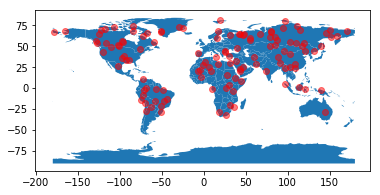

In [10]:
world = gpd.read_file(
  gpd.datasets.get_path('naturalearth_lowres')
)
ax = plt.subplot(1, 1, 1)
ax = world.plot(ax=ax)
ax = gdf_land.plot(ax=ax,color="red", alpha=0.5)